In [7]:
%pip install nibabel
%pip install monai

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
import os
import nibabel as nib
import glob


import os
for dirname, _, filenames in os.walk('./DATA'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./DATA/.DS_Store
./DATA/labelsTr/la_004.nii/la_004.nii
./DATA/labelsTr/la_010.nii/la_010.nii
./DATA/labelsTr/la_011.nii/la_011.nii
./DATA/labelsTr/la_005.nii/la_005.nii
./DATA/labelsTr/la_007.nii/la_007.nii
./DATA/labelsTr/la_016.nii/la_016.nii
./DATA/labelsTr/la_003.nii/la_003.nii
./DATA/labelsTr/la_017.nii/la_017.nii
./DATA/labelsTr/la_029.nii/la_029.nii
./DATA/labelsTr/la_014.nii/la_014.nii
./DATA/labelsTr/la_019.nii/la_019.nii
./DATA/labelsTr/la_018.nii/la_018.nii
./DATA/labelsTr/la_030.nii/la_030.nii
./DATA/labelsTr/la_024.nii/la_024.nii
./DATA/labelsTr/la_026.nii/la_026.nii
./DATA/labelsTr/la_023.nii/la_023.nii
./DATA/labelsTr/la_022.nii/la_022.nii
./DATA/labelsTr/la_020.nii/la_020.nii
./DATA/labelsTr/la_021.nii/la_021.nii
./DATA/labelsTr/la_009.nii/la_009.nii
./DATA/imagesTr/la_004.nii/la_004.nii
./DATA/imagesTr/la_010.nii/la_010.nii
./DATA/imagesTr/la_011.nii/la_011.nii
./DATA/imagesTr/la_005.nii/la_005.nii
./DATA/imagesTr/la_007.nii/la_007.nii
./DATA/imagesTr/la_016.nii/la_016

In [9]:
# Directory paths
train_images_dir = './DATA/imagesTr'
train_labels_dir = './DATA/labelsTr'
test_images_dir = './DATA/imagesTs'

# List all files
train_image_files = sorted([f for f in os.listdir(train_images_dir) if f.endswith('.nii')])
train_label_files = sorted([f for f in os.listdir(train_labels_dir) if f.endswith('.nii')])
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith('.nii')])

print(f"Number of training images: {len(train_image_files)}")
print(f"Number of training labels: {len(train_label_files)}")
print(f"Number of test images: {len(test_image_files)}")

# Function to safely load nii files
def safe_load_nii(filepath):
    try:
        img = nib.load(filepath)
        img_data = img.get_fdata()
        if img_data.size == 0:
            raise nib.filebasedimages.ImageFileError("Empty file")
        return img_data
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# Load and summarize a sample image
sample_image_path = os.path.join(train_images_dir, train_image_files[0])
sample_image_data = safe_load_nii(sample_image_path)

if sample_image_data is not None:
    print(f"Sample image shape: {sample_image_data.shape}")
    print(f"Sample image data type: {sample_image_data.dtype}")
else:
    print("Sample image is empty or corrupted.")

Number of training images: 20
Number of training labels: 20
Number of test images: 10
Error loading ./DATA/imagesTr/la_003.nii: Cannot work out file type of "DATA/imagesTr/la_003.nii"
Sample image is empty or corrupted.


these transformations prepare the medical images and labels for input into a deep learning model by standardizing their format, enhancing their features, and augmenting the dataset for better training.

In [10]:
from monai.transforms import (
  AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImage,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    DivisiblePadd,
    RandAffined,
    RandRotated,
    RandGaussianNoised
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from datetime import datetime



In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
data_dir = "./DATA"
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*/*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*/*.nii")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-4], data_dicts[-4:] # 16 train and 4 validation
train_files


[{'image': './DATA/imagesTr/la_003.nii/la_003.nii',
  'label': './DATA/labelsTr/la_003.nii/la_003.nii'},
 {'image': './DATA/imagesTr/la_004.nii/la_004.nii',
  'label': './DATA/labelsTr/la_004.nii/la_004.nii'},
 {'image': './DATA/imagesTr/la_005.nii/la_005.nii',
  'label': './DATA/labelsTr/la_005.nii/la_005.nii'},
 {'image': './DATA/imagesTr/la_007.nii/la_007.nii',
  'label': './DATA/labelsTr/la_007.nii/la_007.nii'},
 {'image': './DATA/imagesTr/la_009.nii/la_009.nii',
  'label': './DATA/labelsTr/la_009.nii/la_009.nii'},
 {'image': './DATA/imagesTr/la_010.nii/la_010.nii',
  'label': './DATA/labelsTr/la_010.nii/la_010.nii'},
 {'image': './DATA/imagesTr/la_011.nii/la_011.nii',
  'label': './DATA/labelsTr/la_011.nii/la_011.nii'},
 {'image': './DATA/imagesTr/la_014.nii/la_014.nii',
  'label': './DATA/labelsTr/la_014.nii/la_014.nii'},
 {'image': './DATA/imagesTr/la_016.nii/la_016.nii',
  'label': './DATA/labelsTr/la_016.nii/la_016.nii'},
 {'image': './DATA/imagesTr/la_017.nii/la_017.nii',
  '

In [13]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),        
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16)
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16)
    ]
)

augm_transforms = Compose(
    [
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.5),
    ]
)

/Users/mac/Library/Python/3.9/lib/python/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [14]:
train_ds = CacheDataset(data=train_files, transform=train_transforms)

# 16 images -> transform + data augmentation
augm_ds= CacheDataset(data=train_files, transform=[train_transforms, augm_transforms])

train_ds = ConcatDataset([train_ds, augm_ds])

train_loader = DataLoader(train_ds)

val_ds = CacheDataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds)

Loading dataset: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
model = UNet(
    spatial_dims=3,
    in_channels=1, # hard labeling
    out_channels=2, # soft labeling
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout =0.2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax = True)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, amsgrad = True)
early_stopper = EarlyStopper(patience=3, min_delta=0.3)

In [17]:
total_time = 0
max_epochs = 10 #better to be upto 100
val_interval = 1 
print_interval = 20
epoch_loss_values = []
losses_validation = []

for epoch in range(max_epochs):
    start_time = datetime.now()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train() 
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    # Measuring Training time for each epoch       
    actual_time = datetime.now() - start_time
    print(f"time to train this epoch: {actual_time}")
    total_time += actual_time.total_seconds()
    # saving the loss for the actual epoch
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval() 
        with torch.no_grad():
            loss_val = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                
                outputs = model(val_inputs)
                loss_val = loss_function(outputs, val_labels).item()
                
            loss_val_avg = loss_val / val_loader.batch_size
            losses_validation.append(loss_val_avg)
            print(f"validation average loss: {loss_val_avg:.4f}")
            if early_stopper.early_stop(loss_val_avg):
                print("early stopped!")
                break

----------
epoch 1/10
time to train this epoch: 0:01:55.566037
epoch 1 average loss: 1.4530
validation average loss: 1.4811
----------
epoch 2/10
time to train this epoch: 0:01:53.768729
epoch 2 average loss: 1.3779
validation average loss: 1.3903
----------
epoch 3/10
time to train this epoch: 0:01:50.840137
epoch 3 average loss: 1.3142
validation average loss: 1.2746
----------
epoch 4/10
time to train this epoch: 0:01:54.602596
epoch 4 average loss: 1.2425
validation average loss: 1.2080
----------
epoch 5/10
time to train this epoch: 0:01:56.185226
epoch 5 average loss: 1.1728
validation average loss: 1.1625
----------
epoch 6/10
time to train this epoch: 0:01:55.891998
epoch 6 average loss: 1.1231
validation average loss: 1.1085
----------
epoch 7/10
time to train this epoch: 0:01:56.654142
epoch 7 average loss: 1.0839
validation average loss: 1.0993
----------
epoch 8/10
time to train this epoch: 0:01:56.016096
epoch 8 average loss: 1.0473
validation average loss: 1.0410
--------

In [18]:
torch.save(model, "unet3dAdamwDicece.pth")

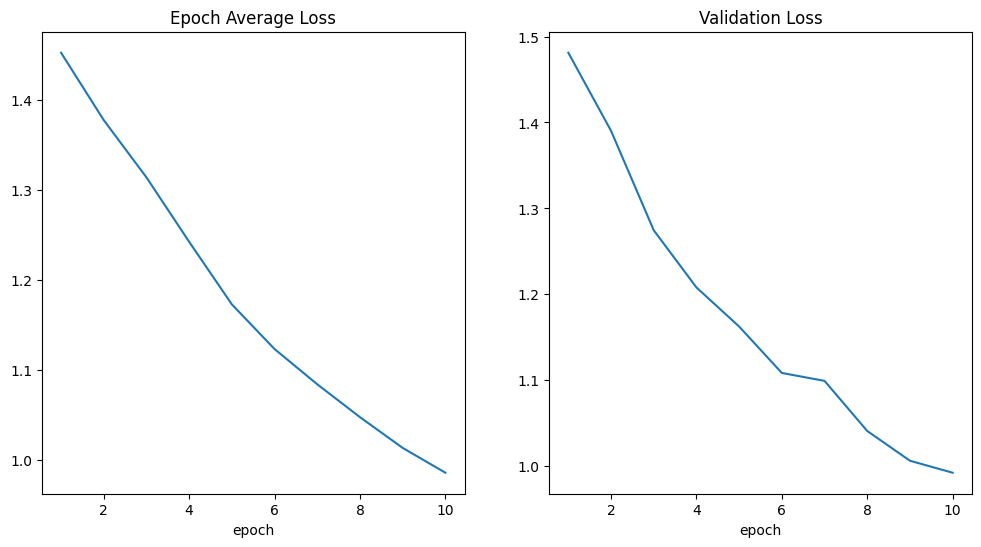

In [19]:
%matplotlib inline
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation Loss")
x = [val_interval * (i + 1) for i in range(len(losses_validation))]
y = losses_validation
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


In [20]:
images = []
outputs = []
labels = []
for val_data in val_loader: 
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
    )
    images.append(val_inputs)
    outputs.append(model(val_inputs))
    labels.append(val_labels)

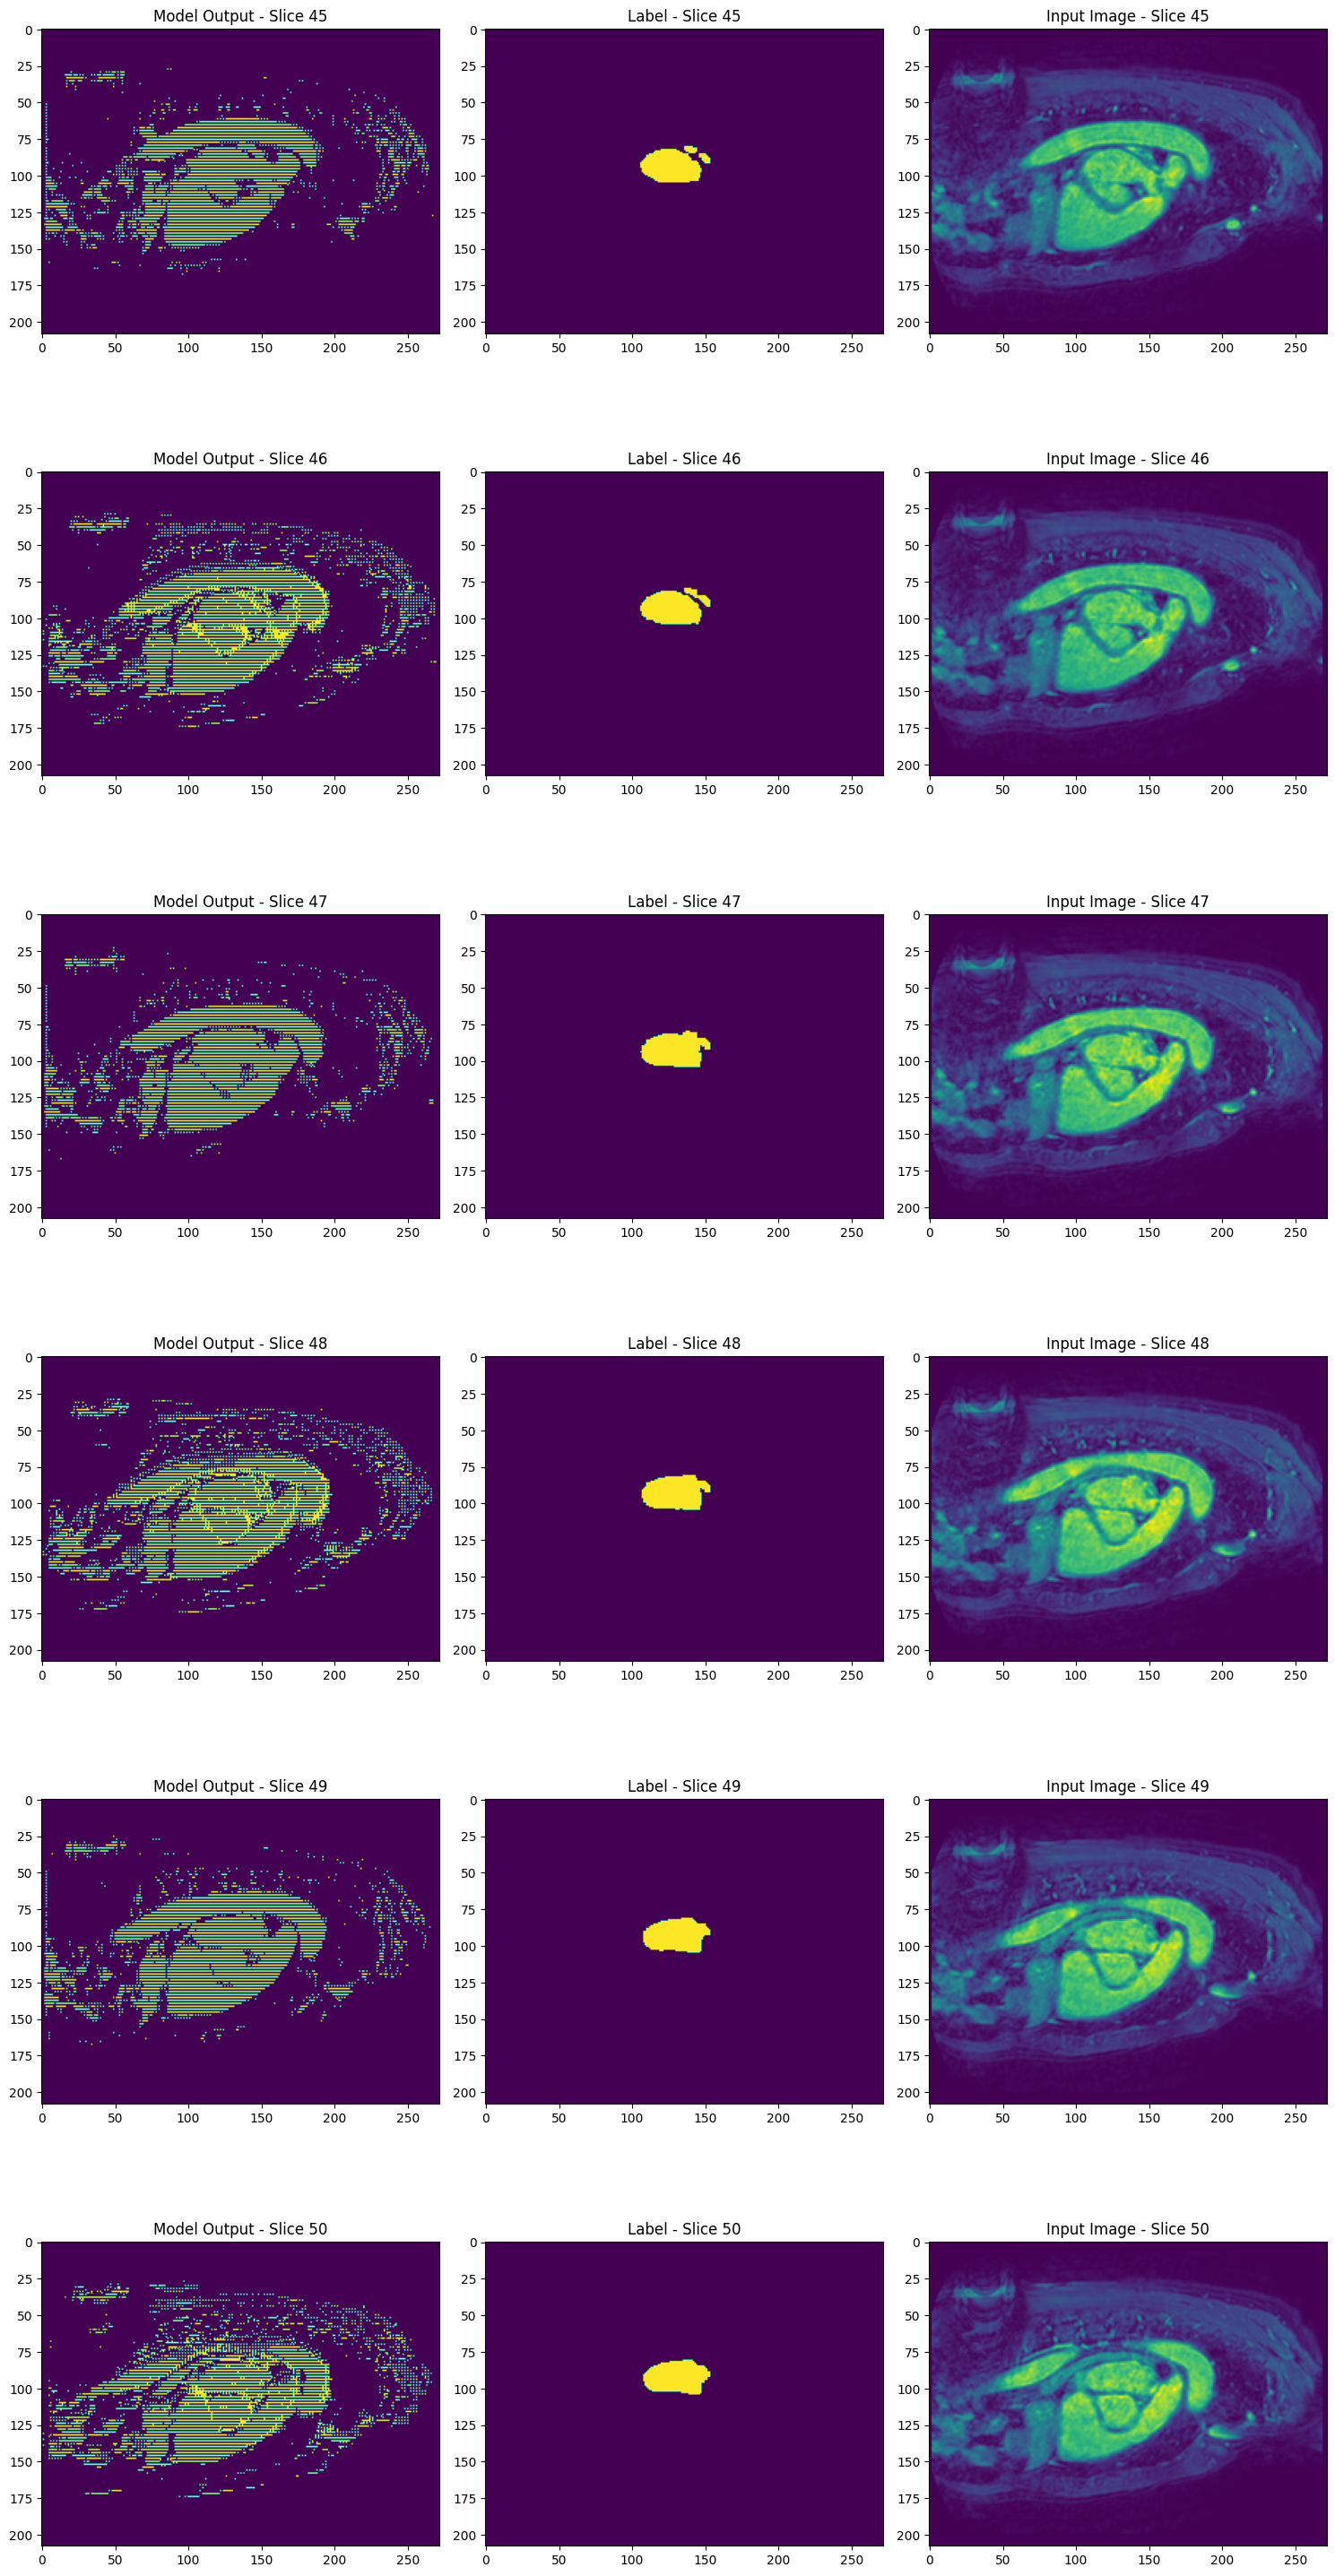

In [21]:
output = outputs[0]
label = labels[0][0][0]
image = images[0][0][0]

# Set the slice range from 45 to 50
slice_start = 45
slice_end = 51

# Calculate the number of slices
num_slices = slice_end - slice_start

# Create a subplot with 'num_slices' rows and 3 columns
plt.figure(figsize=(15, 5 * num_slices))

for i in range(num_slices):
    # Increment the slice index
    current_slice = slice_start + i
    # Plot the Model Output
    plt.subplot(num_slices, 3, 3 * i + 1)
    with torch.no_grad():
        plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
    plt.title(f'Model Output - Slice {current_slice}')

    # Plot the Label
    plt.subplot(num_slices, 3, 3 * i + 2)
    plt.imshow(label.cpu()[:, :, current_slice])
    plt.title(f'Label - Slice {current_slice}')

    # Plot the Input Image
    plt.subplot(num_slices, 3, 3 * i + 3)
    plt.imshow(image.cpu()[:, :, current_slice])
    plt.title(f'Input Image - Slice {current_slice}')
    
# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

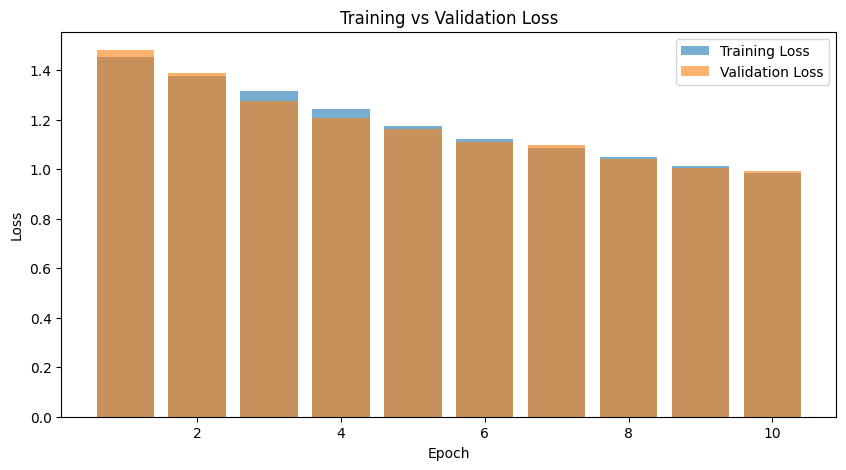

In [22]:
# 1. Bar Graph for training vs validation loss
epochs = [i + 1 for i in range(len(epoch_loss_values))]

plt.figure(figsize=(10, 5))
plt.bar(epochs, epoch_loss_values, alpha=0.6, label='Training Loss')
plt.bar(epochs, losses_validation, alpha=0.6, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

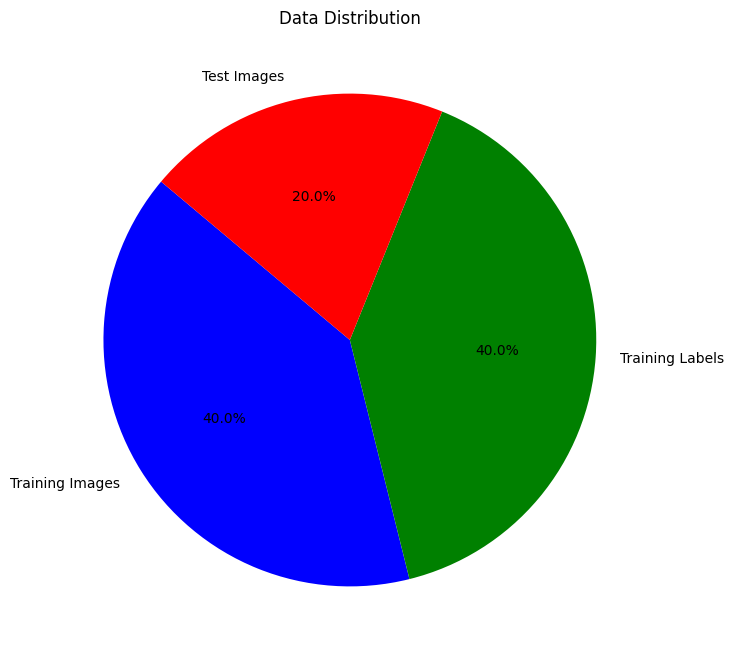

In [23]:
num_training_images = len(train_image_files)
num_training_labels = len(train_label_files)
num_test_images = len(test_image_files)


# Pie Chart
plt.figure(figsize=(8, 8))
labels = ['Training Images', 'Training Labels', 'Test Images']
sizes = [num_training_images, num_training_labels, num_test_images]
colors = ['blue', 'green', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Data Distribution')
plt.show()

In [24]:
data = { 
 "name": "LeftAtrium", 
 "description": "Left atrium segmentation",
"tensorImageSize": "3D",
"reference": "King’s College London",
"licence":"CC-BY-SA 4.0",
"relase":"1.0 04/05/2018",
"modality": { 
	 "0": "MRI"
 }, 
 "labels": { 
	 "0": "background", 
	 "1": "left atrium"
 }, 
 "numTraining": 20, 
 "numTest": 10,
 "training":[{"image":"./imagesTr/la_007.nii.gz","label":"./labelsTr/la_007.nii.gz"},{"image":"./imagesTr/la_019.nii.gz","label":"./labelsTr/la_019.nii.gz"},{"image":"./imagesTr/la_023.nii.gz","label":"./labelsTr/la_023.nii.gz"},{"image":"./imagesTr/la_005.nii.gz","label":"./labelsTr/la_005.nii.gz"},{"image":"./imagesTr/la_009.nii.gz","label":"./labelsTr/la_009.nii.gz"},{"image":"./imagesTr/la_017.nii.gz","label":"./labelsTr/la_017.nii.gz"},{"image":"./imagesTr/la_021.nii.gz","label":"./labelsTr/la_021.nii.gz"},{"image":"./imagesTr/la_029.nii.gz","label":"./labelsTr/la_029.nii.gz"},{"image":"./imagesTr/la_003.nii.gz","label":"./labelsTr/la_003.nii.gz"},{"image":"./imagesTr/la_011.nii.gz","label":"./labelsTr/la_011.nii.gz"},{"image":"./imagesTr/la_030.nii.gz","label":"./labelsTr/la_030.nii.gz"},{"image":"./imagesTr/la_022.nii.gz","label":"./labelsTr/la_022.nii.gz"},{"image":"./imagesTr/la_014.nii.gz","label":"./labelsTr/la_014.nii.gz"},{"image":"./imagesTr/la_018.nii.gz","label":"./labelsTr/la_018.nii.gz"},{"image":"./imagesTr/la_020.nii.gz","label":"./labelsTr/la_020.nii.gz"},{"image":"./imagesTr/la_004.nii.gz","label":"./labelsTr/la_004.nii.gz"},{"image":"./imagesTr/la_016.nii.gz","label":"./labelsTr/la_016.nii.gz"},{"image":"./imagesTr/la_024.nii.gz","label":"./labelsTr/la_024.nii.gz"},{"image":"./imagesTr/la_010.nii.gz","label":"./labelsTr/la_010.nii.gz"},{"image":"./imagesTr/la_026.nii.gz","label":"./labelsTr/la_026.nii.gz"}],
 "test":["./imagesTs/la_015.nii.gz","./imagesTs/la_025.nii.gz","./imagesTs/la_013.nii.gz","./imagesTs/la_001.nii.gz","./imagesTs/la_027.nii.gz","./imagesTs/la_006.nii.gz","./imagesTs/la_008.nii.gz","./imagesTs/la_012.nii.gz","./imagesTs/la_028.nii.gz","./imagesTs/la_002.nii.gz"]
 }

# Extracting training and test data information
num_training_images = data["numTraining"]
num_test_images = data["numTest"]
training_files = data["training"]
test_files = data["test"]

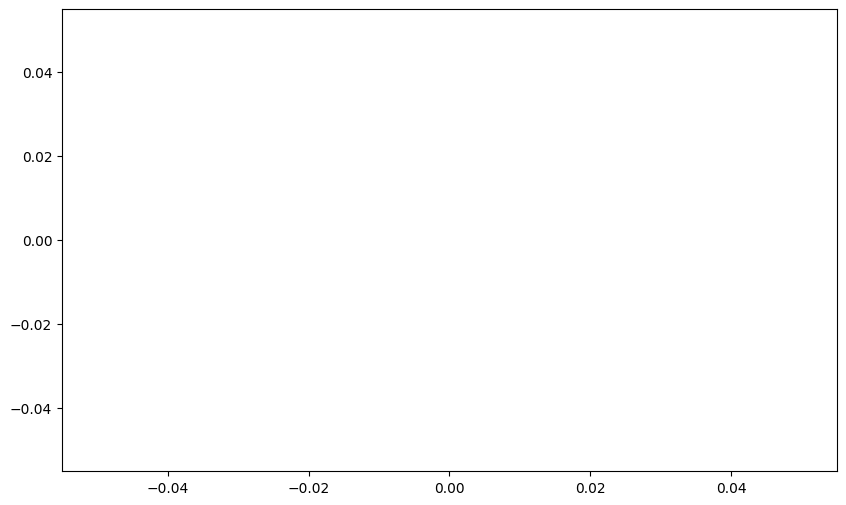

In [27]:
# Scatter Plot
# Assuming the first dimension of the shape as the X axis and the second as the Y axis for a sample image
sample_image_shape = sample_image_data.shape if sample_image_data is not None else (0, 0, 0)
x = np.arange(sample_image_shape[0])
y = np.arange(sample_image_shape[1])
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='purple')
plt.title('Scatter Plot of Sample Image Dimensions')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [30]:
import seaborn as sns

# Box Plot
# Using the sample image data for box plot demonstration
if sample_image_data is not None:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=sample_image_data.flatten())
    plt.title('Box Plot of Sample Image Data')
    plt.show()

In [31]:
# Histogram
# Using the sample image data for histogram demonstration
if sample_image_data is not None:
    plt.figure(figsize=(10, 6))
    plt.hist(sample_image_data.flatten(), bins=30, color='orange')
    plt.title('Histogram of Sample Image Data')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()